In [1]:
%env THEANO_FLAGS=device=gpu1,lib.cnmem=0.6

import lasagne

import theano
import theano.tensor as T

import numpy as np

import os
from preprocessing import jpg_to_nparray

from IPython.display import clear_output
from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline

env: THEANO_FLAGS=device=gpu1,lib.cnmem=0.6
Couldn't import dot_parser, loading of dot files will not be possible.


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 1: GeForce GTX 1080 (CNMeM is enabled with initial size: 60.0% of memory, cuDNN 5110)


In [2]:
from lasagne.layers import (InputLayer, Conv2DLayer, Pool2DLayer, DenseLayer, 
                            ReshapeLayer, Upscale2DLayer, Deconv2DLayer, batch_norm)
from lasagne.layers import get_output, get_all_params
from lasagne.nonlinearities import LeakyRectify, tanh

lref = LeakyRectify(0.2)

In [3]:
def buildGenerator(input_shape, input_var=None):
    net = InputLayer(input_shape, input_var)
    
    net = DenseLayer(net, 256 * 8 * 8, nonlinearity=tanh)
    net = ReshapeLayer(net, [-1, 256, 8, 8])
    
    net = Upscale2DLayer(net, 2)
    net = batch_norm(Deconv2DLayer(net, 256, 5, nonlinearity=lref))
    
    net = Upscale2DLayer(net, 2)
    net = batch_norm(Deconv2DLayer(net, 128, 5, nonlinearity=lref))
    
    net = batch_norm(Deconv2DLayer(net, 64, 5, nonlinearity=lref))
    net = batch_norm(Deconv2DLayer(net, 32, 5, nonlinearity=lref))   
    net = batch_norm(Deconv2DLayer(net, 16, 5, nonlinearity=lref))    
    net = batch_norm(Deconv2DLayer(net, 16, 5, nonlinearity=lref))    
    net = batch_norm(Deconv2DLayer(net, 16, 3, nonlinearity=lref))    
    net = Deconv2DLayer(net, 3, 3, nonlinearity=None)    
    
    return net

In [4]:
def buildDiscriminator(input_shape, input_var=None):
    inp = InputLayer(input_shape, input_var)
    
    net = Conv2DLayer(inp, 128, 5)
    net = Pool2DLayer(net, 2)
    
    net = Conv2DLayer(net, 256, 5)
    
    net = DenseLayer(net, 256)
    net = DenseLayer(net, 1, nonlinearity=None)
    
    return inp, net

In [5]:
inputPicShape = [None, 3, 64, 64]
inputPic = T.tensor4("Input Pic", "float32")

inputNoiseShape = [None, 100]
inputNoise = T.matrix("Input Noise", "float32")

In [6]:
generator = buildGenerator(inputNoiseShape, inputNoise)
disc_inp, discriminator = buildDiscriminator(inputPicShape, inputPic)

In [7]:
clip=1e-3

adam = {"learning_rate" : 1e-4, "beta1" : 0, "beta2" : 0.9}

class training:
    generated_img = get_output(generator)
    
    scr_real = get_output(discriminator, inputs=inputPic)
    scr_fake = get_output(discriminator, generated_img)
    
    g_loss = -scr_fake.mean()
    d_loss = -(scr_real - scr_fake).mean()
    
    g_params = get_all_params(generator, trainable=True)
    d_params = get_all_params(discriminator, trainable=True)
    
    g_updates = lasagne.updates.adam(g_loss, g_params, **adam)
    d_updates = lasagne.updates.adam(d_loss, d_params, **adam)
    
    g_train = theano.function([inputNoise], g_loss, updates=g_updates, allow_input_downcast=True)
    d_train = theano.function([inputNoise, inputPic], d_loss, updates=d_updates, allow_input_downcast=True)
    
    d_clip_updates ={param : param.clip(-clip, clip) for param in d_updates}
    
    clip = theano.function([],updates=d_clip_updates)

/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: UserWarning: The parameter 'updates' of theano.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (theano.compat.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.


In [8]:
pics = jpg_to_nparray("lamoda/", os.listdir("lamoda/"), [64, 64])

def sample_noise(M):
    ns = np.random.normal(0, 10, size=M)
    return np.float32(ns)

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(pics.shape[0]), size=bsize)
    return pics[idxs].reshape(-1, 3, 64, 64)

In [ ]:
generate = theano.function([inputNoise], training.generated_img, allow_input_downcast=True)

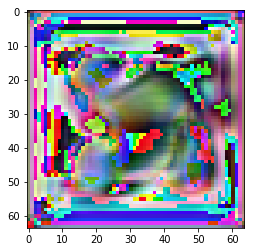

In [13]:
loss = list()
batch_size = 16

for ep in range(20):
    print(ep)
    for i in range(0, 2000, batch_size):
        nz = [sample_noise([100]) for _ in range(batch_size)]
        ims = pics[i : i + batch_size]
        
        for n_crit in range(5):
            loss.append(training.d_train(nz, ims))
            training.clip()
        
        training.g_train(nz)
    
    clear_output()
    plt.imshow(generate(sample_noise([1, 100]))[0].transpose(1, 2, 0))
    plt.show()

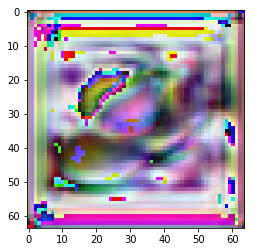

In [16]:
pic = generate(sample_noise([1, 100]))[0].transpose(1, 2, 0)
plt.imshow(pic)

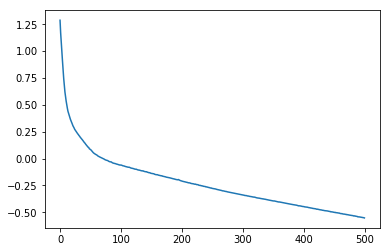

In [10]:
loss = list()

for ep in range(500):
    loss.append(training.g_train(sample_noise([50, 100])))
    
plt.plot(loss)

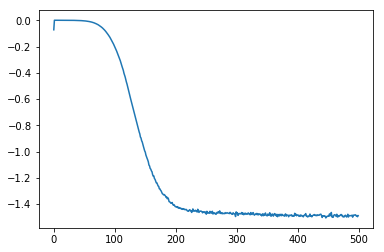

In [9]:
loss = list()

for i in range(500):
    loss.append(training.d_train(sample_noise([50, 100]), sample_data_batch(50)))
    training.clip()
    
plt.plot(loss)